<a href="https://colab.research.google.com/github/kouhei1970/colab_test/blob/main/loopshape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install control

In [2]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mass=0.035 #kg
gravity=9.81 #m/s^2
Ct=1.e-8 # thrust coefficient
Cq=9.71e-11 # torque coefficient
kappa = Cq/Ct
Dm=3.25e-8 #motor 粘性抵抗係数
Rm = 0.34 # motor resistance
Km = 6.15e-4 # motor torque constant
Jm=2.01e-8 # motor rotor inertia
Ix=9.16e-6 # moment of inertia around x axis
Iy=13.3e-6 # moment of inertia around y axis
Iz=20.4e-6 # moment of inertia around z axis
motor_arm_length = 0.065/2 # motor arm length
omega0=0.5*np.sqrt(mass*gravity/Ct)
motor_transfer_function_den = Dm*Rm+Km**2+2*Rm*Cq*omega0
motor_time_constant = (Jm*Rm)/motor_transfer_function_den
motor_gain = Km/motor_transfer_function_den

roll_gain  = 2*motor_arm_length*Ct*omega0*motor_gain/Ix
pitch_gain = 2*motor_arm_length*Ct*omega0*motor_gain/Iy
yaw_gain   = 2*kappa*Ct*omega0*motor_gain/Iz

print("omega0=", omega0, "rad/s" )
print("omega0=", omega0*60/(2*np.pi), "rpm" )
print("motor_time_constant=", motor_time_constant)
print("motor_gain=", motor_gain)
print("roll_gain=", roll_gain)
print("pitch_gain=", pitch_gain)
print("yaw_gain=", yaw_gain)

omega0= 2929.8037476936915 rad/s
omega0= 27977.564924076672 rpm
motor_time_constant= 0.011727677322467796
motor_gain= 1055.387994339727
roll_gain= 219.4161359941975
pitch_gain= 151.11667712081575
yaw_gain= 29.43538617407769


In [4]:
sys_roll = ctrl.tf([roll_gain], [motor_time_constant, 1, 0])
sys_pitch = ctrl.tf([pitch_gain], [motor_time_constant, 1, 0])
sys_yaw = ctrl.tf([yaw_gain], [motor_time_constant, 1, 0])

#margin
gain_margin_roll, phase_margin_roll, _, _ = ctrl.margin(sys_roll)
gain_margin_pitch, phase_margin_pitch, _, _ = ctrl.margin(sys_pitch)
gain_margin_yaw, phase_margin_yaw, _, _ = ctrl.margin(sys_yaw)

print("sys_roll=", sys_roll)
print("sys_pitch=", sys_pitch)
print("sys_yaw=", sys_yaw)

print("\n#Margin")
print("phase_margin_roll=", phase_margin_roll)
print("phase_margin_pitch=", phase_margin_pitch)
print("phase_margin_yaw=", phase_margin_yaw)


sys_roll= <TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

       219.4
  ---------------
  0.01173 s^2 + s
sys_pitch= <TransferFunction>: sys[1]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

       151.1
  ---------------
  0.01173 s^2 + s
sys_yaw= <TransferFunction>: sys[2]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

       29.44
  ---------------
  0.01173 s^2 + s

#Margin
phase_margin_roll= 34.47276289049421
phase_margin_pitch= 40.80759167286007
phase_margin_yaw= 71.83981278431233


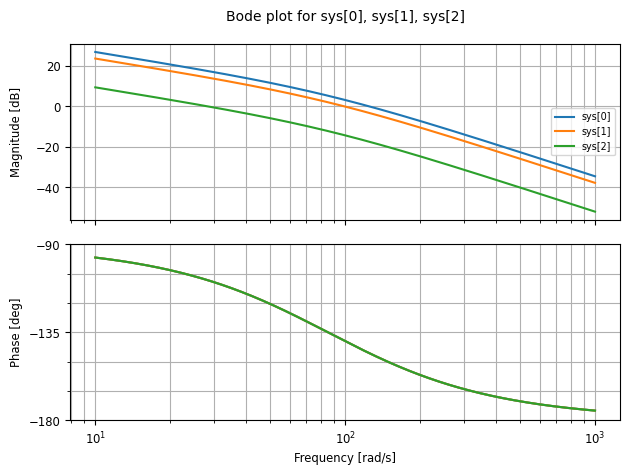

In [5]:
#bode plot
ctrl.bode([sys_roll,sys_pitch,sys_yaw], dB=True)
plt.show()

In [6]:
Kp_roll =  0.72
Kp_pitch = 1.045
Kp_yaw = 5.37
sys_roll_loop = Kp_roll * sys_roll
sys_pitch_loop = Kp_pitch * sys_pitch
sys_yaw_loop = Kp_yaw * sys_yaw
gain_margin_roll_loop, phase_margin_roll_loop, gain_cross_freq_roll, phase_cross_freq_roll = ctrl.margin(sys_roll_loop)
gain_margin_pitch_loop, phase_margin_pitch_loop, gain_cross_freq_pitch, phase_cross_freq_pitch = ctrl.margin(sys_pitch_loop)
gain_margin_yaw_loop, phase_margin_yaw_loop, gain_cross_freq_yaw, phase_cross_freq_yaw = ctrl.margin(sys_yaw_loop)

print("phase_margin_roll_loop=", phase_margin_roll_loop)
print("phase_cross_freq_roll=", phase_cross_freq_roll)
print("phase_margin_pitch_loop=", phase_margin_pitch_loop)
print("phase_cross_freq_pitch=", phase_cross_freq_pitch)
print("phase_margin_yaw_loop=", phase_margin_yaw_loop)
print("phase_cross_freq_yaw=", phase_cross_freq_yaw)


phase_margin_roll_loop= 40.01252462676618
phase_cross_freq_roll= 101.57379290845198
phase_margin_pitch_loop= 40.019583239036876
phase_cross_freq_pitch= 101.54838553700199
phase_margin_yaw_loop= 40.002576772788274
phase_cross_freq_yaw= 101.60961272651238


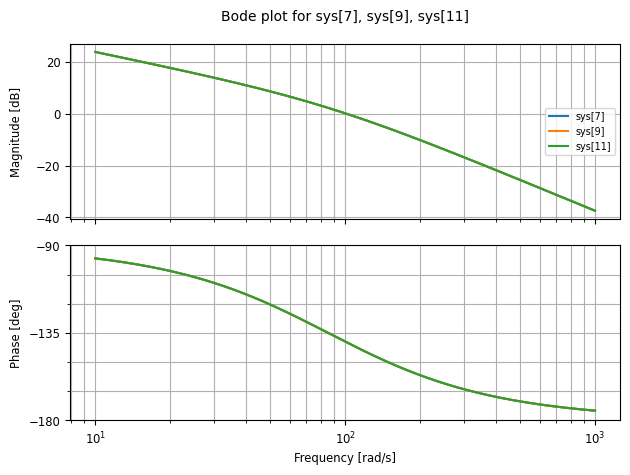

In [7]:
ctrl.bode([sys_roll_loop, sys_pitch_loop,sys_yaw_loop], dB=True)
plt.show()

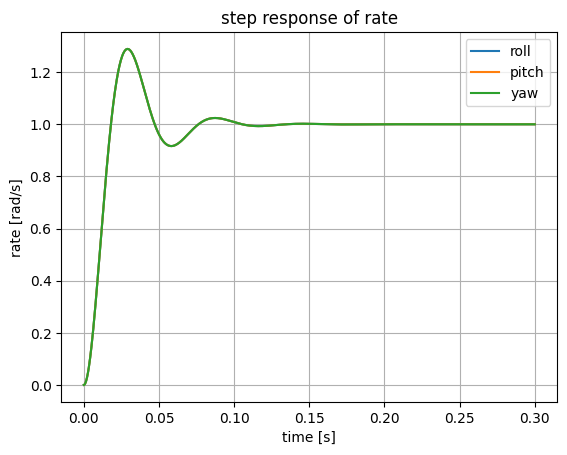

In [8]:
sys_roll_close = ctrl.feedback(sys_roll_loop, 1)
sys_pitch_close = ctrl.feedback(sys_pitch_loop, 1)
sys_yaw_close = ctrl.feedback(sys_yaw_loop, 1)
t0 = np.linspace(0, 0.3, 1000)
t1, y1 = ctrl.step_response(sys_roll_close, t0)
t2, y2 = ctrl.step_response(sys_pitch_close, t0)
t3, y3 = ctrl.step_response(sys_pitch_close, t0)

plt.plot(t1, y1)
plt.plot(t2, y2)
plt.plot(t3, y3)
plt.grid()
plt.title("step response of rate")
plt.xlabel("time [s]")
plt.ylabel("rate [rad/s]")
plt.legend(["roll", "pitch", "yaw"])
plt.show()

In [36]:
#不完全微分付きPIDコントローラ
#roll
kp_roll=0.0475
ti_roll=0.8
td_roll = 0.8
eta_roll = 0.0125
sysi_roll = ctrl.tf(1, [ti_roll, 0])
sysd_roll = ctrl.tf([td_roll, 0], [eta_roll*td_roll, 1])
sys_roll_pid = kp_roll*(1+sysi_roll + sysd_roll)
print(sys_roll_pid)

#pitch
kp_pitch=0.07
ti_pitch=0.8
td_pitch = 0.8
eta_pitch = 0.0125
sysi_pitch = ctrl.tf(1, [ti_pitch, 0])
sysd_pitch = ctrl.tf([td_pitch, 0], [eta_pitch*td_pitch, 1])
sys_pitch_pid = kp_pitch*(1+sysi_pitch + sysd_pitch)
print(sys_pitch_pid)

#yaw
kp_yaw=0.06
ti_yaw=0.8
td_yaw = 0.8
eta_yaw = 0.0125
sysi_yaw = ctrl.tf(1, [ti_yaw, 0])
sysd_yaw = ctrl.tf([td_yaw, 0], [eta_yaw*td_yaw, 1])
sys_yaw_pid = kp_yaw*(1+sysi_yaw + sysd_yaw)
print(sys_yaw_pid)

gain_margin_roll_loop, phase_margin_roll_loop, gain_cross_freq_roll, phase_cross_freq_roll = ctrl.margin(sys_roll*sys_roll_pid)
gain_margin_pitch_loop, phase_margin_pitch_loop, gain_cross_freq_pitch, phase_cross_freq_pitch = ctrl.margin(sys_pitch*sys_pitch_pid)
gain_margin_yaw_loop, phase_margin_yaw_loop, gain_cross_freq_yaw, phase_cross_freq_yaw = ctrl.margin(sys_yaw*sys_yaw_pid)

print("phase_margin_roll_loop=", phase_margin_roll_loop)
print("phase_cross_freq_roll=", phase_cross_freq_roll)
print("phase_margin_pitch_loop=", phase_margin_pitch_loop)
print("phase_cross_freq_pitch=", phase_cross_freq_pitch)
print("phase_margin_yaw_loop=", phase_margin_yaw_loop)
print("phase_cross_freq_yaw=", phase_cross_freq_yaw)

<TransferFunction>: sys[639]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  0.03078 s^2 + 0.03848 s + 0.0475
  --------------------------------
         0.008 s^2 + 0.8 s
<TransferFunction>: sys[646]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  0.04536 s^2 + 0.0567 s + 0.07
  -----------------------------
        0.008 s^2 + 0.8 s
<TransferFunction>: sys[653]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  0.03888 s^2 + 0.0486 s + 0.06
  -----------------------------
        0.008 s^2 + 0.8 s
phase_margin_roll_loop= 40.09589177815056
phase_cross_freq_roll= 251.7152941830845
phase_margin_pitch_loop= 39.78698544302651
phase_cross_freq_pitch= 253.84477041998457
phase_margin_yaw_loop= 112.45291675492774
phase_cross_freq_yaw= 60.30224286365466


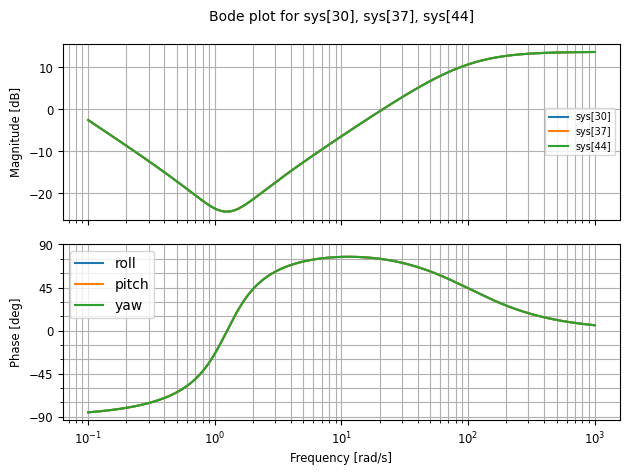

In [10]:
ctrl.bode([sys_roll_pid,sys_pitch_pid,sys_yaw_pid], dB=True)
plt.legend(["roll", "pitch", "yaw"])
plt.show()

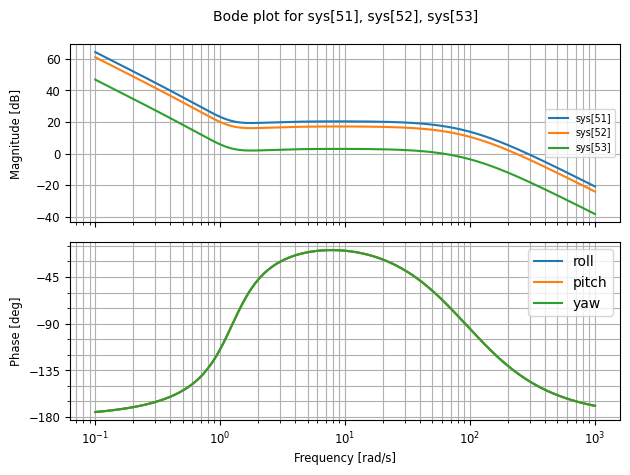

In [11]:
ctrl.bode([sys_roll_pid*sys_roll, sys_pitch_pid*sys_pitch, sys_yaw_pid*sys_yaw], dB=True)
plt.legend(["roll", "pitch", "yaw"])
plt.show()